In [1]:
import os
os.environ["NUMBA_NUM_THREADS"] = "1"

from ast import literal_eval
import numpy as np
from atmos_cloud_sim_uj_utils import show_plot
from matplotlib import pyplot
from joblib import Parallel, delayed, parallel_backend

In [2]:
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling

from PySDM_examples.Abdul_Razzak_Ghan_2000.aerosol import AerosolFigure1, AerosolFigure2
from PySDM_examples.Abdul_Razzak_Ghan_2000.settings import Settings
from PySDM_examples.Abdul_Razzak_Ghan_2000.simulation import Simulation

In [ ]:
def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    # output["aerosol"] = settings.aerosol
    # output["bins"] = settings.wet_radius_bins_edges
    output["settings"] = settings
    return key, output

with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(f"mode2N_{norm_factor_2}", Settings(
        nsteps=100, 
        n_sd_per_mode=10, 
        T0 = 300.0 * si.K,
        aerosol=AerosolFigure2(mode2N = norm_factor_2 / si.cm ** 3),
        spectral_sampling=spec_sampling.ConstantMultiplicity
        ))
        for norm_factor_2 in np.linspace(100, 5000, 5)
    ))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.6s remaining:   48.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.6s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.0s finished


In [32]:
for name in output.keys():
    att = output[name]["attributes"]
    settings = output[name]["settings"]
    total_drops_in_mode_1 = 0
    activated_drops_in_mode_1 = 0
    for i, volume in enumerate(att['volume']):
        if i < settings.n_sd_per_mode:
            final_vol = volume[-1]
            final_crit_vol = att['critical volume'][i][-1]
            if final_vol > final_crit_vol:
                print("activated")
                activated_drops_in_mode_1 += att['n'][i][-1]
            total_drops_in_mode_1 += att['n'][i][-1]

    output[name]["activated frac mode 1"] = activated_drops_in_mode_1 / total_drops_in_mode_1
    output[name]["error estimate"] = np.amax(att['n'][:settings.n_sd_per_mode][-1]) / total_drops_in_mode_1

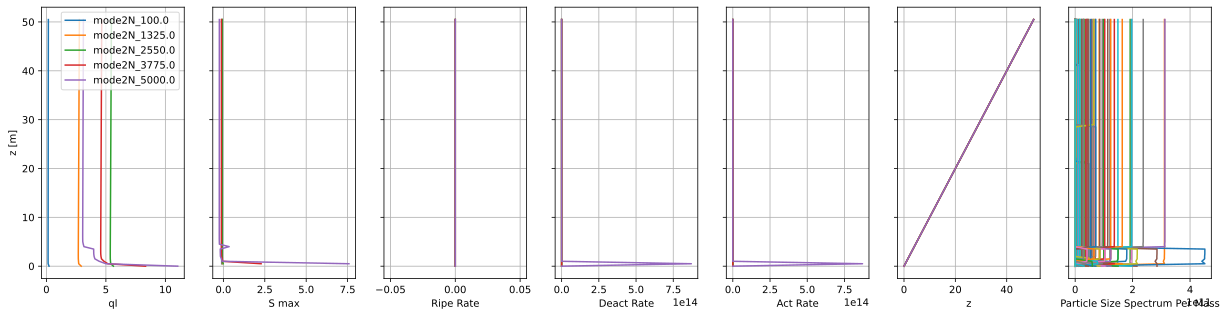

HTML(value="<a href='./parcel.pdf' target='_blank'>./parcel.pdf</a><br>")

In [6]:
# Plot parcel profiles

for key in output.keys():
    products = output[key]["products"]
    N = len(products)
fig, axs = pyplot.subplots(1, N, sharey="all", figsize=(N*3,5))

for key in output.keys():
    products = output[key]["products"]
    for i, p in enumerate(products):
        axs[i].plot(products[p], products['z'], label=key)
        axs[i].set_xlabel(p)
        axs[i].set_yscale("linear")
        axs[i].grid()
    axs[0].set_ylabel("z [m]")
    axs[0].legend(loc=1)
show_plot('parcel.pdf')

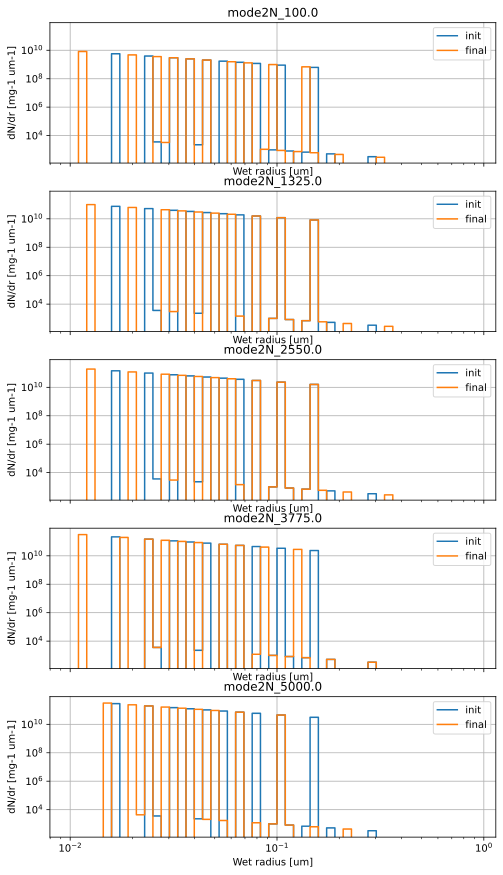

HTML(value="<a href='./parcel_size_dist.pdf' target='_blank'>./parcel_size_dist.pdf</a><br>")

In [11]:
# Plot parcel size distribution

fig, ax = pyplot.subplots(5, 1, sharex=True, sharey=True, figsize=(8,15))
for i, key in enumerate(output.keys()):
    bins = output[key]["settings"].wet_radius_bins_edges
    spectra = output[key]["products"]["Particle Size Spectrum Per Mass"]

    ax[i].step(x=bins[:-1] / si.um, y=spectra[0], where='post', label="init")
    ax[i].step(x=bins[:-1] / si.um, y=spectra[-1], where='post', label="final")
    ax[i].set_xscale('log')
    ax[i].set_yscale("log")
    #ax[i].set_ylim([1e-1, 1e5])
    ax[i].legend(loc='best')
    ax[i].grid()
    ax[i].set_title(key)
    ax[i].set_xlabel("Wet radius [um]")
    ax[i].set_ylabel(f"dN/dr [mg-1 um-1]")

#pyplot.tight_layout()
#fig.subplots_adjust(top=0.88)
show_plot('parcel_size_dist.pdf')

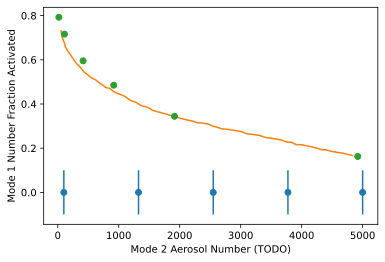

HTML(value="<a href='./fig_2.pdf' target='_blank'>./fig_2.pdf</a><br>")

In [31]:
N_2_obs = [18.74716810149539, 110.41572270049846, 416.00589034889026, 918.1014952424102, 1914.816492976891, 4919.913910285455]
N_act_obs = [0.7926937018577255, 0.7161078386950611, 0.5953670140462167, 0.4850589034888989, 0.34446080652469424, 0.162630267331219]
N_2_paper_param = [54.6839601268689, 72.69483461712753, 109.48119619392855, 127.7469415496148, 155.44290892614436, 183.2238332578163,
                   220.2650657000454, 275.8269143633893, 312.86814680561884, 368.5999093792484, 433.50702310829183, 554.4007702763934,
                   628.9080199365658, 693.9850475758949, 740.5414589941097, 787.0129134571821, 852.3448119619393, 917.4218396012684,
                   973.3235160851837, 1047.915722700498, 1103.8173991844137, 1178.2396918894428, 1234.1413683733576,1280.7827367467153,
                   1364.5502945174449,1467.1782963298592,1513.734707748075, 1560.2911191662893, 1709.5604893520617, 1765.547122791119,
                   1849.4845944721342, 1989.408699592207, 2092.0367014046215, 2157.3685999093796, 2222.7004984141367, 2297.292705029451,
                   2353.364295423651, 2456.07725419121, 2549.2750339827826, 2605.26166742184, 2689.199139102854, 2810.6026280018123,
                   2997.3380154055285, 3099.8810602628, 3221.2845491617572, 3314.6522428636154, 3389.2444494789315, 3463.9216130493887,
                   3566.634571816946, 3650.657000453103, 3762.5453103760756, 3827.9621658359765, 3911.814680561849, 3995.922066153149,
                   4126.585863162664, 4247.904395106479, 4322.496601721793, 4397.258722247395, 4490.54145899411, 4574.563887630267,
                   4667.9315813321255, 4835.891481649297]
N_act_paper_param = [0.7307884005437245, 0.7016538287267784, 0.676110104213865, 0.657884005437245, 0.643271409152696, 0.6322949705482556,
                     0.6176597190756684, 0.5957068418667876, 0.5810715903942004, 0.5663910285455369, 0.5444154961486181, 0.5186678749433621,
                     0.5075781603987314, 0.49287494336202997, 0.48548935206162214, 0.4744676030811056, 0.47067285908473044, 0.45596964204802903,
                     0.4485613955595833, 0.4411078386950612, 0.43369959220661536, 0.41897371998187594, 0.4115654734934301, 0.4078160398731311,
                     0.39306751246035343, 0.3855459900317173, 0.37816039873130947, 0.37077480743090174, 0.3595038513819666, 0.3557317625736294,
                     0.3482555505210695, 0.33700724966017237, 0.32948572723153613, 0.325690983235161, 0.32189623923878585, 0.31444268237426376,
                     0.31430675124603535, 0.31042138649750806, 0.2992863615768011, 0.2955142727684641, 0.2880380607159041, 0.28410738559130055,
                     0.27638196647032176, 0.265224286361577, 0.2612936112369735, 0.25743090167648397, 0.249977344811962, 0.24615994562754873,
                     0.24227458087902143, 0.23843452650657015, 0.22725419120978696, 0.22709560489352065, 0.21598323516085194, 0.21577933846850939,
                     0.2081898504757591, 0.20062301767104684, 0.19316946080652464, 0.19298821930222032, 0.1854893520616221, 0.18164929768917082,
                     0.17778658812868153, 0.16647032170367027]

norm_factor_2 = [float(key.split("_")[-1]) for key in output.keys()]

modei = 1
args_common = {"yerr" : [val["error estimate"] for val in output.values()], "fmt" : 'o'}
pyplot.errorbar(
    norm_factor_2,
    [np.nanmax(val["activated frac mode 1"]) for val in output.values()], 
    **args_common
)
# pyplot.errorbar(
#     norm_factor_2,
#     [np.nanmax(val["act_frac_B"][modei]) for val in output.values()], 
#     **args_common
# )
pyplot.plot(N_2_paper_param, N_act_paper_param)
pyplot.plot(N_2_obs, N_act_obs,"o")
pyplot.ylabel('Mode 1 Number Fraction Activated')
pyplot.xlabel('Mode 2 Aerosol Number (TODO)')

show_plot("fig_2.pdf")